In [1]:
import trimesh
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
glb_file = "/home/vlongle/.objaverse/hf-objaverse-v1/glbs/000-064/ecb91f433f144a7798724890f0528b23.glb"
# ply_output_path = "ficus_voxel_cache.ply"
ply_output_path = "/home/vlongle/code/diffPhys3d/render_outputs/ecb91f433f144a7798724890f0528b23/clip_features_pc.ply"
overwrite=False

In [3]:
def center_and_normalize_mesh(mesh):
    # Get the center of the bounding box
    center = mesh.bounds.mean(axis=0)
    
    # Create translation to center the mesh at origin
    translation = -center
    
    # Get the scaling factor to fit in a unit cube
    scale_factor = 1.0 / max(mesh.extents)
    
    # Apply the transformations
    mesh = mesh.copy()
    mesh.apply_translation(translation)
    mesh.apply_scale(scale_factor)
    
    return mesh

In [4]:
def load_mesh(glb_file):
    scene = trimesh.load(glb_file)
    meshes = list(scene.geometry.values())
    # Concatenate all meshes into a single mesh
    if len(meshes) > 1:
        print(f"Concatenating {len(meshes)} meshes")
        mesh = trimesh.util.concatenate(meshes)

    mesh = center_and_normalize_mesh(mesh)
    ## number of points in the mesh
    num_points = len(mesh.vertices)
    print(f"Number of points in the mesh: {num_points}")

    ## number of faces in the mesh
    num_faces = len(mesh.faces)
    print(f"Number of faces in the mesh: {num_faces}")
    return mesh

In [5]:
def save_points_to_ply(points, output_path):
    """
    Save points to a PLY file that's compatible with load_point_cloud function.
    
    Args:
        points: Numpy array of shape (N, 3) containing point coordinates
        output_path: Path to save the PLY file
    """
    from plyfile import PlyData, PlyElement
    
    # Create a structured array for the PLY file
    vertex_data = np.zeros(points.shape[0], dtype=[
        ('x', 'f4'), ('y', 'f4'), ('z', 'f4')
    ])
    
    # Fill in the coordinates
    vertex_data['x'] = points[:, 0]
    vertex_data['y'] = points[:, 1]
    vertex_data['z'] = points[:, 2]
    
    # Create PlyElement
    vertex_element = PlyElement.describe(vertex_data, 'vertex')
    
    # Create PlyData and write to file
    ply_data = PlyData([vertex_element])
    ply_data.write(output_path)
    
    print(f"Saved {points.shape[0]} points to {output_path}")


In [6]:
if not os.path.exists(ply_output_path) or overwrite:
    mesh = load_mesh(glb_file)
    pitch = 0.005
    voxelized = mesh.voxelized(pitch=pitch)
    points = voxelized.points  # (N,3)
    save_points_to_ply(points, ply_output_path)
else:
    from gs_simulation_pc import load_point_cloud
    point_cloud_data = load_point_cloud(ply_output_path)
    points = point_cloud_data['pos'].cpu().numpy()
    print(f"Loaded {points.shape[0]} points from {ply_output_path}")


[Taichi] version 1.5.0, llvm 15.0.4, commit 7b885c28, linux, python 3.9.21


[I 03/31/25 19:03:34.061 292585] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout
/home/vlongle/miniconda3/envs/PhysGaussian/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/vlongle/miniconda3/envs/PhysGaussian/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Warp 0.10.1 initialized:
   CUDA Toolkit: 11.5, Driver: 12.5
   Devices:
     "cpu"    | x86_64
     "cuda:0" | NVIDIA RTX A6000 (sm_86)
     "cuda:1" | NVIDIA GeForce RTX 3080 (sm_86)
     "cuda:2" | NVIDIA GeForce RTX 3080 (sm_86)
   Kernel cache: /home/vlongle/.cache/warp/0.10.1
[Taichi] Starting on arch=cuda
plydata ply
format binary_little_endian 1.0
comment Created by Open3D
element vertex 17924
property double x
property double y
property double z
property uchar red
property uchar green
property uchar blue
end_header
Loaded point cloud with 17924 points
Color information was successfully loaded
Loaded 17924 points from /home/vlongle/code/diffPhys3d/render_outputs/ecb91f433f144a7798724890f0528b23/clip_features_pc.ply


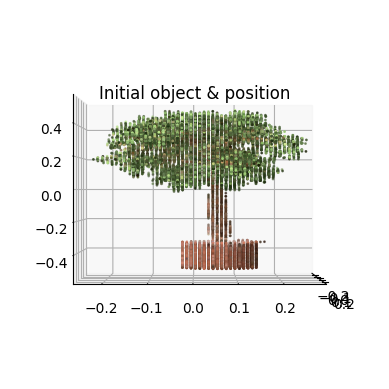

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1,
           c=point_cloud_data['colors'].cpu().numpy())
ax.set_title(f"Initial object & position", y = 0.8)

ax.view_init(elev=0, azim=0)
plt.show()

In [ ]:
points.shape

For gaussian splatting, we have 110322 about 100k points. For our voxelization code, we have 19644 points at pitch=0.01, and 70k at pitch=0.005. For our nerf, we have 17924 points so around 18k points.